# 쇼핑몰 지점별 매출액 예측 경진대회

## 데이터 불러오기

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm import tqdm

warnings.filterwarnings('ignore')

In [20]:
sns.set_theme(style='white')

In [4]:
os.getcwd()

'C:\\Users\\Jaesu\\github_desktop\\Dacon-Basic\\쇼핑몰지점별-매출액-예측\\쇼핑몰지점별-매출액-EDA모델링'

In [7]:
os.chdir('C:\\Users\\Jaesu\\github_desktop\\Dacon-Basic\\쇼핑몰지점별-매출액-예측')

In [382]:
df = pd.read_csv('./Data/train.csv')
test = pd.read_csv('./Data/test.csv')
submission = pd.read_csv('./Data/sample_submission.csv')

In [383]:
df.drop('id', axis=1, inplace=True)
test.drop('id', axis=1, inplace=True)

## 데이터 전처리 및 파생변수 생성

- Data 변수를 날짜 형식으로 변경하여 연, 월, 일 변수를 생성

`-` 또한 2010년을 기준으로 연월일을 하루 단위로 변환하여 2010년으로부터 며칠이 지났는지를 알 수 있는 변수를 생성하겠다  

In [384]:
def get_date(df) -> None:
    """df['Date']에서 연, 월, 일 변수를 생성""" 
    df['Date'] = pd.to_datetime(df['Date'])
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day

In [385]:
get_date(df)
get_date(test)

In [386]:
df['Day_Range'] = (df['Date'] - pd.datetime(2010, 1, 1)).dt.days
test['Day_Range'] = (test['Date'] - pd.datetime(2010, 1, 1)).dt.days

- 공휴일 변수를 숫자로 변경

In [387]:
df['IsHoliday'] = df['IsHoliday'].apply(lambda x: 1 if x else 0)
test['IsHoliday'] = test['IsHoliday'].apply(lambda x: 1 if x else 0)

- 프로모션의 결측치를 $-1$로 대체

In [388]:
df.fillna(value=-1, inplace=True)
test.fillna(value=-1, inplace=True)

- 총 프로모션 비용 변수 생성

In [389]:
df['Promotion_Cost'] = df[['Promotion1', 'Promotion2', 'Promotion3', 'Promotion4', 'Promotion5']].sum(axis=1)
test['Promotion_Cost'] = test[['Promotion1', 'Promotion2', 'Promotion3', 'Promotion4', 'Promotion5']].sum(axis=1)

- 연말 유무를 판단하는 변수 생성

In [390]:
df['IsYearEnd'] = df['Month'].apply(lambda x: 1 if x == 12 else 0)
test['IsYearEnd'] = test['Month'].apply(lambda x: 1 if x == 12 else 0)

In [391]:
df.head()

,Store,Date,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,IsHoliday,Weekly_Sales,Year,Month,Day,Day_Range,Promotion_Cost,IsYearEnd
0,1,2010-05-02,42.31,2.572,-1.0,-1.0,-1.0,-1.0,-1.0,8.106,0,1643690.90,2010,5,2,121,-5.0,0
1,1,2010-12-02,38.51,2.548,-1.0,-1.0,-1.0,-1.0,-1.0,8.106,1,1641957.44,2010,12,2,335,-5.0,1
2,1,2010-02-19,39.93,2.514,-1.0,-1.0,-1.0,-1.0,-1.0,8.106,0,1611968.17,2010,2,19,49,-5.0,0
3,1,2010-02-26,46.63,2.561,-1.0,-1.0,-1.0,-1.0,-1.0,8.106,0,1409727.59,2010,2,26,56,-5.0,0
4,1,2010-05-03,46.50,2.625,-1.0,-1.0,-1.0,-1.0,-1.0,8.106,0,1554806.68,2010,5,3,122,-5.0,0


- 쇼핑몰 지점 군집화

<AxesSubplot:xlabel='Weekly_Sales', ylabel='Count'>

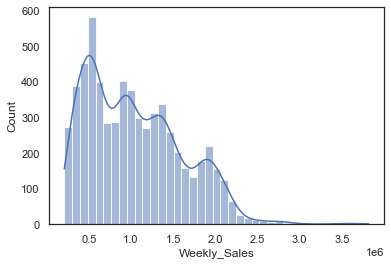

In [49]:
sns.histplot(data=df, x='Weekly_Sales', kde=True)

<AxesSubplot:xlabel='Store', ylabel='Weekly_Sales'>

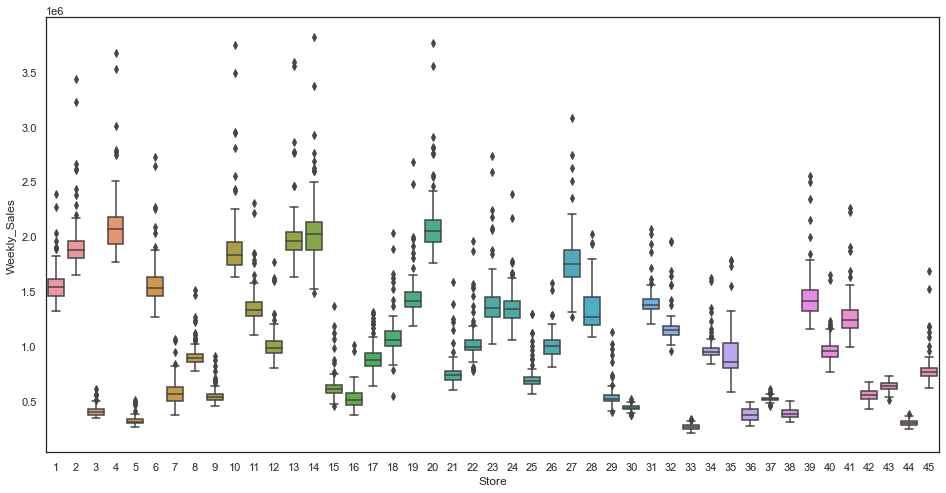

In [21]:
plt.figure(figsize=(16, 8))
sns.boxplot(data=df, y='Weekly_Sales', x='Store')

`-` 비슷한 분포를 띄는 쇼핑몰 지점을 군집화하자 (매출액의 중앙값과 IQR, 지난 일수와의 상관계수가 비슷해야 함)

In [131]:
tmp = df.groupby(by='Store').agg({'Weekly_Sales':[np.median, lambda x: np.quantile(x, q=0.75) - np.quantile(x, q=0.25)]}).\
        reset_index().rename(columns={'<lambda_0>':'IQR'}).melt(id_vars='Store').\
        rename(columns={'variable_1':'statistic'}).drop('variable_0', axis=1)

<AxesSubplot:>

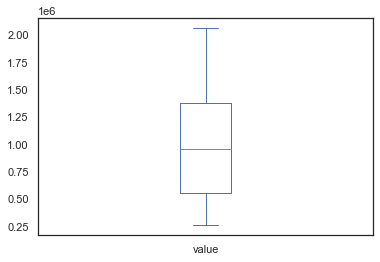

In [134]:
tmp.query('statistic == "median"').value.plot.box()

<AxesSubplot:>

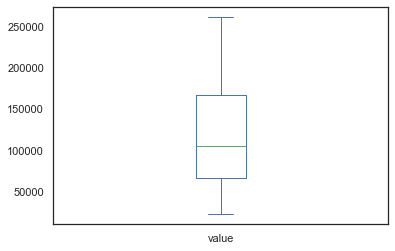

In [135]:
tmp.query('statistic == "IQR"').value.plot.box()

`-` 매출액의 중앙값과 사분위수 범위가 비슷한 쇼핑몰 지점끼리 군집화하겠다

`-` 나의 능지 문제로 일단은 일일이 분류하겠다

`-` 나중에 함수로 만들든 클래스로 만들든 해가지고 이를 사용해 분류하겠다


In [194]:
median_bins = [-np.inf]
for i in range(1, 8):
    value = np.quantile(tmp.query('statistic == "median"').value, q=i/8)
    median_bins.append(value)
median_bins.append(np.inf)

In [195]:
cuts = pd.cut(tmp.query('statistic == "median"').value, bins=median_bins, labels=list(range(1, 9)))

In [210]:
store_df = pd.DataFrame(data=range(1, 46), columns=['Store'])

In [211]:
store_df['Cut'] = cuts

In [212]:
store_df = store_df.merge(tmp.query('statistic == "median"').drop('statistic', axis=1))

- 사후처리

`-` 군집내에서 쇼핑몰 지점별 중앙값의 차이가 큰 경우 군집을 쪼개겠다

`-` 또한, 군집내에서 사분위수 범위가 유사한 것끼리 다시 군집화하겠다

In [223]:
store_df.groupby(['Cut', 'Store', 'value']).sample().sort_values(by=['Cut', 'value'])

,Store,Cut,value
32,33,1,258427.39
43,44,1,296947.06
4,5,1,310013.11
35,36,1,374182.04
37,38,1,378539.17
2,3,1,394918.83
29,30,2,438068.71
15,16,2,509942.56
36,37,2,517546.69
28,29,2,518628.42


## 모델링

In [225]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [231]:
SEED = 22

In [226]:
def RMSE(true, pred):
    score = np.sqrt(np.mean(np.square(true - pred)))
    return score

In [229]:
def OOF_predict(model, X, y, test, SKfold, stratify):
    """
    Out-Of-Fold 방식을 통해 test(numeric)를 예측
    train, valid에 대한 NMAE score와 예측한 test를 return
    """ 
    model_train_score = []
    model_valid_score = []
    model_pred = np.zeros(shape=(test.shape[0]))

    for i, (train_idx, valid_idx) in enumerate(SKfold.split(X, X[stratify])):
        # print(f'({i + 1} / {SKfold.n_splits}) Fold Training......')
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_valid, y_valid = X.iloc[valid_idx], y.iloc[valid_idx]
        
        ## 모델 적합
        model.fit(X_train, y_train)
        
        ## prediction
        train_pred = model.predict(X_train) ## train
        valid_pred = model.predict(X_valid) ## valid
        test_pred = model.predict(test) ## test
        
        model_train_score.append(RMSE(y_train, train_pred)) ## train NMAE
        model_valid_score.append(RMSE(y_valid, valid_pred)) ## valid NMAE
        model_pred += test_pred / SKfold.n_splits ## test 예측값(k Fold)
              
    return model_train_score, model_valid_score, model_pred

In [328]:
RF = RandomForestRegressor(n_estimators=500,
                           max_depth=12,
                           min_samples_split=2,
                           random_state=SEED)

EXT = ExtraTreesRegressor(n_estimators=500,
                          max_depth=15,
                          min_samples_split=2,
                          random_state=SEED)

GD = GradientBoostingRegressor(n_estimators=500,
                               learning_rate=0.05,
                               max_depth=6,
                               min_samples_split=3,
                               random_state=SEED)

CB = CatBoostRegressor(n_estimators=700,
                       learning_rate=0.05,
                       max_depth=7,
                       random_state=SEED,
                       verbose=0)

XGB = XGBRegressor(n_estimators=500,
                   learning_rate=0.05,
                   max_depth=6,
                   random_state=SEED)

LGBM = LGBMRegressor(n_estimators=500,
                     learning_rate=0.05,
                     max_depth=8,
                     random_state=SEED)

In [406]:
features = [
            'Store',
            'Temperature',
            'Fuel_Price',
            'Unemployment',
            'IsHoliday',
            'Promotion_Cost',
            #'IsYearEnd',
            'Year',
            'Month',
            'Day_Range',
           ]

In [393]:
target = df['Weekly_Sales']
df.drop('Weekly_Sales', axis=1, inplace=True)

In [394]:
df2 = df[features] ## 교호작용 X
test2 = test[features]

In [395]:
k = 5
skfold1 = StratifiedKFold(k, shuffle=True, random_state=SEED)
skfold2 = StratifiedKFold(k, shuffle=True, random_state=SEED*2)

- 모델 학습

In [304]:
_, RF_valid_RMSE1, RF_test_pred1 = OOF_predict(RF, df2, target, test2, skfold1, stratify='Store')
_, RF_valid_RMSE2, RF_test_pred2 = OOF_predict(RF, df2, target, test2, skfold2, stratify='Store')
print(f'{RF.__class__.__name__} -> Mean: {np.mean(RF_valid_RMSE1 + RF_valid_RMSE2)}, Std: {np.std(RF_valid_RMSE1 + RF_valid_RMSE2)}')

RandomForestRegressor -> Mean: 157875.42601005337, Std: 7922.675258314715


In [307]:
_, EXT_valid_RMSE1, EXT_test_pred1 = OOF_predict(EXT, df2, target, test2, skfold1, stratify='Store')
_, EXT_valid_RMSE2, EXT_test_pred2 = OOF_predict(EXT, df2, target, test2, skfold2, stratify='Store')
print(f'{EXT.__class__.__name__} -> Mean: {np.mean(EXT_valid_RMSE1 + EXT_valid_RMSE2)}, Std: {np.std(EXT_valid_RMSE1 + EXT_valid_RMSE2)}')

ExtraTreesRegressor -> Mean: 147467.29945345293, Std: 8885.620570331603


In [375]:
_, GD_valid_RMSE1, GD_test_pred1 = OOF_predict(GD, df2, target, test2, skfold1, stratify='Store')
_, GD_valid_RMSE2, GD_test_pred2 = OOF_predict(GD, df2, target, test2, skfold2, stratify='Store')
print(f'{GD.__class__.__name__} -> Mean: {np.mean(GD_valid_RMSE1 + GD_valid_RMSE2)}, Std: {np.std(GD_valid_RMSE1 + GD_valid_RMSE2)}')

GradientBoostingRegressor -> Mean: 106176.89563230696, Std: 4758.9315940279685


In [329]:
_, CB_valid_RMSE1, CB_test_pred1 = OOF_predict(CB, df2, target, test2, skfold1, stratify='Store')
_, CB_valid_RMSE2, CB_test_pred2 = OOF_predict(CB, df2, target, test2, skfold2, stratify='Store')
print(f'{CB.__class__.__name__} -> Mean: {np.mean(CB_valid_RMSE1 + CB_valid_RMSE2)}, Std: {np.std(CB_valid_RMSE1 + CB_valid_RMSE2)}')

CatBoostRegressor -> Mean: 102718.08457624466, Std: 4962.214773495546


In [327]:
_, XGB_valid_RMSE1, XGB_test_pred1 = OOF_predict(XGB, df2, target, test2, skfold1, stratify='Store')
_, XGB_valid_RMSE2, XGB_test_pred2 = OOF_predict(XGB, df2, target, test2, skfold2, stratify='Store')
print(f'{XGB.__class__.__name__} -> Mean: {np.mean(XGB_valid_RMSE1 + XGB_valid_RMSE2)}, Std: {np.std(XGB_valid_RMSE1 + XGB_valid_RMSE2)}')

XGBRegressor -> Mean: 102185.80407549346, Std: 6226.103952865928


In [330]:
_, LGBM_valid_RMSE1, LGBM_test_pred1 = OOF_predict(LGBM, df2, target, test2, skfold1, stratify='Store')
_, LGBM_valid_RMSE2, LGBM_test_pred2 = OOF_predict(LGBM, df2, target, test2, skfold2, stratify='Store')
print(f'{LGBM.__class__.__name__} -> Mean: {np.mean(LGBM_valid_RMSE1 + LGBM_valid_RMSE2)}, Std: {np.std(LGBM_valid_RMSE1 + LGBM_valid_RMSE2)}')

LGBMRegressor -> Mean: 93369.75245266361, Std: 4254.426456205732


`-` LGBM 모델의 성능이 가장 우수하다

- test 예측 및 제출

`-` test 데이터의 경우 행이 180개로 train 데이터에 비해 매우 적다

`-` 연도는 2012년만 존재하며 월의 경우 5월, 10월, 12월만 존재한다

`-` 오버피팅을 주의해야 한다

`-` LGBM 모델과 XGB 모델은 성능이 좋지 않았으며 Catboost 모델의 성능은 나쁘지 않다

In [371]:
submission['Weekly_Sales'] = (CB_test_pred1 + CB_test_pred2) / 2
submission.head()

,id,Weekly_Sales
0,1,1.618359e+06
1,2,1.686764e+06
2,3,1.242928e+06
3,4,1.271903e+06
4,5,1.845054e+06


<AxesSubplot:>

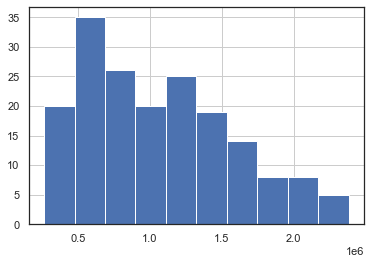

In [376]:
submission['Weekly_Sales'].hist()

In [403]:
# submission.to_csv('./Data/submission5.csv', index=False)